In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import seaborn as sns
from matplotlib import rcParams

In [2]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'

dpi = 200

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/igor-sadalski/Scaling-up-measurement-noise-scaling-laws/main/collect_mi_results.csv')
df.replace('celltype.l3', 'Cell type MI', inplace=True)
df.replace('protein_counts', 'Protein MI', inplace=True)
df.replace('clone', 'Clonal MI', inplace=True)
df.replace('author_day', 'Temporal MI', inplace=True)
df.replace('ng_idx', 'Spatial MI', inplace=True)
df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

In [4]:
# sc_param_df = pd.read_csv('analysis/final_results/cell_scaling_N0_21733.759_s_0.502_I_inf_2.927_I_0_0.730.csv')
# sc_param_df = pd.read_csv('analysis/final_results/cell_scaling_N0_13906.063_s_1.051_I_inf_1.304.csv')
sc_param_df = pd.read_csv('https://raw.githubusercontent.com/igor-sadalski/Scaling-up-measurement-noise-scaling-laws/main/analysis/final_results/cell_scaling_N0_2328676.073_s_1.100_I_inf_3.141.csv')
sc_param_df.replace('celltype.l3', 'Cell type MI', inplace=True)
sc_param_df.replace('protein_counts', 'Protein MI', inplace=True)
sc_param_df.replace('clone', 'Clonal MI', inplace=True)
sc_param_df.replace('author_day', 'Temporal MI', inplace=True)
sc_param_df.replace('ng_idx', 'Spatial MI', inplace=True)
sc_param_df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

In [5]:
sc_param_df['min I'] = [df[(df['signal'] == metric) & (df['quality'] == 1) 
                           & (df['algorithm'] == method)]['mi_value'].min() 
                           for metric, method in zip(sc_param_df['metric'].values, sc_param_df['method'].values)]

In [6]:
pretty_palette = ["#C85158",
                    "#62A48F",
                    "#475A7A",
                    "#503A38",
                    "#E9AD97",
                    "#88A4BA",]

def plot_points(ax, x, y, color, label):
    ax.plot(x, y, color=color, marker='o', alpha=0.6, ms=2.5, label=label, lw=0)

def plot_fit(ax, x, y, color):
    ax.plot(x, y, color=color, linestyle='--', alpha=0.5, lw=0.75, zorder=0.5)

def transform_to_z(x, xbar, imax):
    A = 2**(-2*imax)
    z = ((x/xbar)+A)/(1-A)
    return z

def plot_precomputed(ax, df, param_df, palette, plot_fits=False):
    """plots data that has pre-calculated fit parameters."""
    print('plotting pre-computed data... go!')
    hue_order = ['Geneformer', 'SCVI']

    n_curves = 0

    # loop through all our datasets
    for idx, sig in enumerate(df['signal'].unique()):
        for q in df['quality'].unique():
            if q <= 0.1:
                continue
            for alg in hue_order:
                data = df[(df['signal'] == sig) & (df['quality'] == q) & (df['algorithm'] == alg)]

                if len(data) < 10: continue

                avg_data = data.groupby('size').mi_value.mean()
                x, y = avg_data.index, avg_data.values

                p = param_df[(param_df['metric'] == sig) & (param_df['method'] == alg) & (param_df['quality'] == q)]
                if p.empty: continue
                
                s = p['s'].values[0]
                N0 = p['N0'].values[0]
                I_inf = p['I_inf'].values[0]

                N_hat = (x/N0)**-s

                # # remove if N_hat > I_inf
                # mask = N_hat < I_inf
                # N_hat = N_hat[mask]
                # y = y[mask]

                plot_points(ax, N_hat, I_inf-y, palette[idx], sig)
                if len(y) > 0:
                    n_curves += 1
    print(f'Plotted {n_curves} curves.')

                # if plot_fits:
                #     xs = np.logspace(-4, 3.5, 100)
                #     a, b = 1 / xbar, (1 / xbar) * (2**(2 * imax))
                #     ys = info_scaling(xs, a, b)
                #     plot_fit(ax, xs / xbar, ys / imax, palette[idx])

     dataset      method        metric  quality           N0      s  I_inf  \
0   shendure         PCA   Temporal MI      1.0       37.088  1.094  1.227   
1    merfish         PCA    Spatial MI      1.0       55.178  1.094  1.765   
2      larry         PCA     Clonal MI      1.0       18.336  1.094  1.554   
3       PBMC         PCA  Cell type MI      1.0       31.346  1.089  3.338   
4       PBMC         PCA    Protein MI      1.0       43.223  1.086  3.946   
5      larry  Geneformer     Clonal MI      1.0      121.260  0.582  1.105   
6   shendure  Geneformer   Temporal MI      1.0      165.344  0.402  2.003   
7    merfish  Geneformer    Spatial MI      1.0      107.359  0.332  1.409   
8      larry        SCVI     Clonal MI      1.0      273.811  0.314  2.009   
9    merfish        SCVI    Spatial MI      1.0      665.832  0.255  2.292   
10      PBMC  Geneformer  Cell type MI      1.0      264.892  0.165  3.507   
11  shendure        SCVI   Temporal MI      1.0      207.770  0.

/tmp/ipykernel_3896284/1268275575.py:15: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_3896284/1268275575.py:32: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(


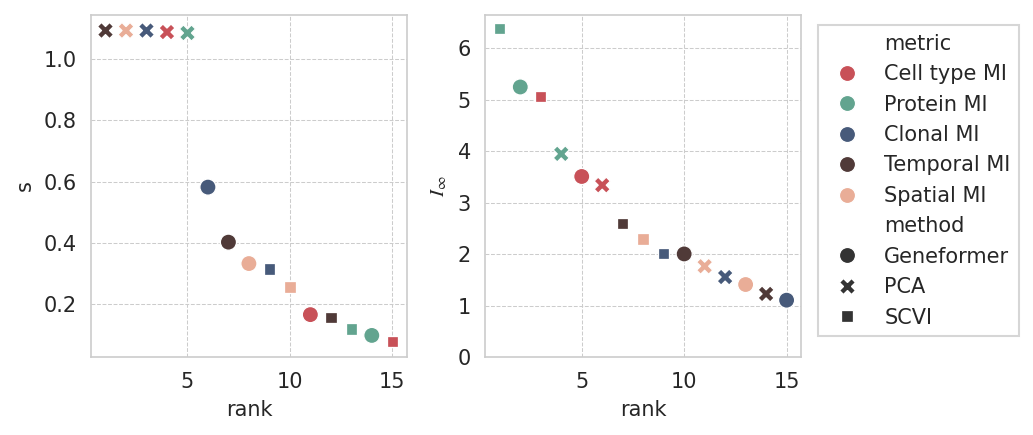

In [7]:
c6 = ['#c4bae2','#40ada6','#3c4ebf',
        '#e3a600', '#d6543a', '#edb1a3']
pretty_palette_2 = [c6[c] for c in range(6) if c in [1,2,3,4]]
hue_order = ['Rand. Proj.', 'PCA', 'SCVI', 'Geneformer']

# compute rank of s (highest to lowest)
subset = sc_param_df[sc_param_df['quality'] == 1]
subset = subset[subset['method'] != 'Rand. Proj.']
ranked = subset.sort_values('s', ascending=False).reset_index(drop=True)
ranked['rank'] = ranked.index + 1
print(ranked)

# plot
fig, axs = plt.subplots(1, 2, figsize=(7,3))
sns.scatterplot(
    data=ranked,
    x='rank', y='s',
    hue='metric',
    palette=pretty_palette,
    style='method',
    s=60,
    edgecolor='w',
    ax=axs[0],
    hue_order=['Cell type MI', 'Protein MI', 'Clonal MI', 'Temporal MI', 'Spatial MI'],
    style_order=['Geneformer', 'PCA', 'SCVI',],
    legend=False
)

ranked = subset.sort_values('I_inf', ascending=False).reset_index(drop=True)
ranked['rank'] = ranked.index + 1

sns.scatterplot(
    data=ranked,
    x='rank', y='I_inf',
    hue='metric',
    palette=pretty_palette,
    style='method',
    s=60,
    edgecolor='w',
    ax=axs[1],
    hue_order=['Cell type MI', 'Protein MI', 'Clonal MI', 'Temporal MI', 'Spatial MI'],
    style_order=['Geneformer', 'PCA', 'SCVI',],
)
plt.xlabel('rank')
axs[1].set_ylabel(r'$I_\infty$')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left',)
plt.ylim(0, )
plt.tight_layout()
plt.show()

/tmp/ipykernel_3896284/2894462737.py:1: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g = sns.scatterplot(


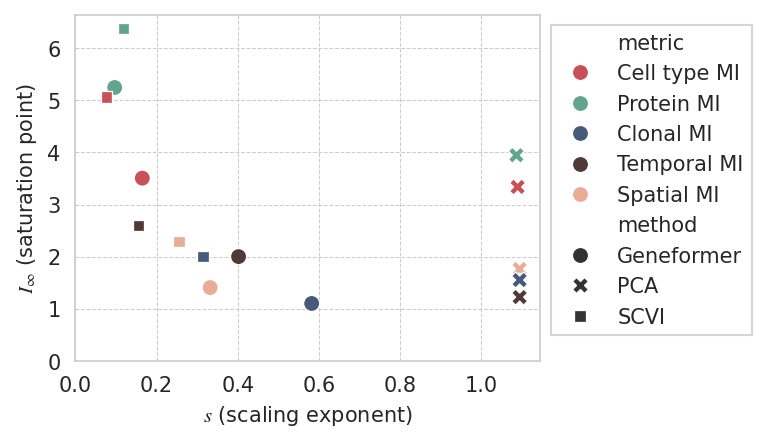

In [8]:
g = sns.scatterplot(
    data=ranked,
    x='s', y='I_inf',
    hue='metric',
    palette=pretty_palette,
    style='method',
    s=60,
    edgecolor='w',
    hue_order=['Cell type MI', 'Protein MI', 'Clonal MI', 'Temporal MI', 'Spatial MI'],
    style_order=['Geneformer', 'PCA', 'SCVI',],
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(r'$s$ (scaling exponent)')
plt.ylabel(r'$I_\infty$ (saturation point)')
plt.xlim(0)
plt.ylim(0)
plt.show()

      dataset       method       metric  quality      N0    s  I_inf  \
189  shendure  Rand. Proj.  Temporal MI      1.0  14.429  1.1  0.689   

     N0_error  s_error  I_inf_error  mean_residual  \
189     52.13    2.001        0.097          0.063   

                                                result    min I  
189  <lmfit.model.ModelResult object at 0x771a888e5...  0.62163  
      dataset method       metric  quality      N0      s  I_inf  N0_error  \
179  shendure    PCA  Temporal MI      1.0  37.088  1.094  1.227     27.58   

     s_error  I_inf_error  mean_residual  \
179    0.767        0.035          0.099   

                                                result    min I  
179  <lmfit.model.ModelResult object at 0x7719b9036...  0.86442  
      dataset method       metric  quality      N0      s  I_inf  N0_error  \
199  shendure   SCVI  Temporal MI      1.0  207.77  0.156  2.597    264.62   

     s_error  I_inf_error  mean_residual  \
199     0.06        0.201          

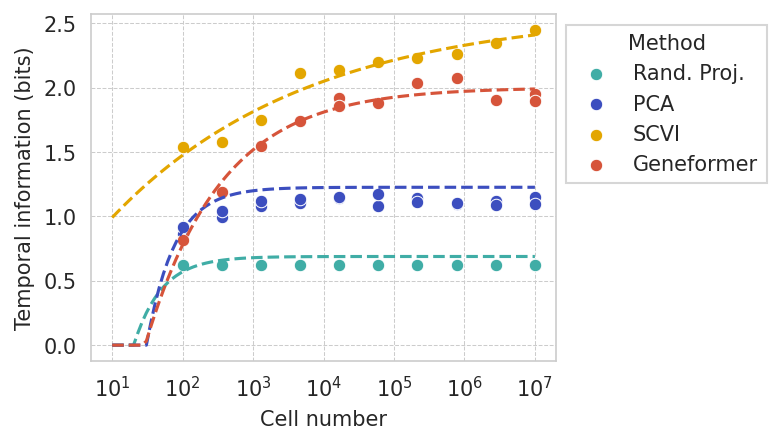

In [9]:
metric = 'Temporal MI'

for method in hue_order:
    subset = sc_param_df[(sc_param_df['quality'] == 1) &
                         (sc_param_df['method'] == method) &
                         (sc_param_df['metric'] == metric)]
    
    print(subset)
    
    s = subset['s'].values[0]
    N0 = subset['N0'].values[0]
    I_inf = subset['I_inf'].values[0]
    # I_0 = subset['I_0'].values[0]

    data = df[(df['quality'] == 1) &
              (df['algorithm'] == method) &
              (df['signal'] == metric)]
    
    sns.scatterplot(
        data=data,
        x='size',
        y=data['mi_value'].values,
        color=pretty_palette_2[hue_order.index(method)],
        label=method,
    )
    xs = np.logspace(1, 7, 100)
    ys = I_inf - (xs / N0) ** -s
    # max 0
    ys = np.maximum(ys, 0)
    # ys = np.maximum(ys, I_0)
    plt.plot(xs, ys, linestyle='--', color=pretty_palette_2[hue_order.index(method)])
plt.xscale('log')
plt.xlabel('Cell number')
plt.ylabel('Temporal information (bits)')
plt.legend(title='Method', bbox_to_anchor=(1, 1), loc='upper left')

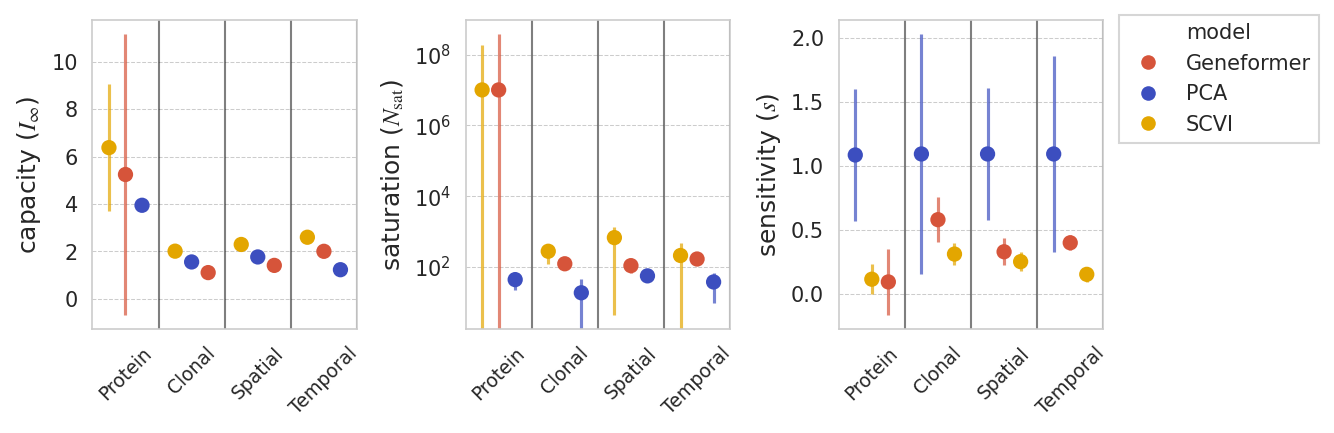

In [10]:
# ---
# panel c (row 2: 1x3 grid)
# ---

fig, axs_param_strips = plt.subplots(1, 3, figsize=(9, 3))

sc_param_df['min I'] = [df[(df['signal'] == metric) & (df['quality'] == 1) 
                           & (df['algorithm'] == method)]['mi_value'].min() 
                           for metric, method in zip(sc_param_df['metric'].values, sc_param_df['method'].values)]

color_dict = {
    "Geneformer": pretty_palette_2[3],
    "PCA": pretty_palette_2[1],
    "SCVI": pretty_palette_2[2],
}

method_order = ["Geneformer", "PCA", "SCVI"]
x_count = 0
all_labels = []
center_positions = []
metric_labels = []

for metric in sc_param_df['metric'].unique():
    if metric == 'Cell type MI':
        continue
    subset = sc_param_df[(sc_param_df['quality'] == 1) &
                         (sc_param_df['metric'] == metric)].copy()
    
    subset['I_inf - min I'] = subset['I_inf'] - subset['min I']
    subset = subset[subset['I_inf - min I'] > 0.2]
    subset = subset[subset['mean_residual'] < 0.75]
    cell_number_min = df[(df['signal'] == metric)]['size'].min()
    subset = subset[~subset['method'].isin(['Rand. Proj.'])]
    
    if subset.empty:
        continue

    n = len(subset)
    positions = x_count + np.arange(n)
    group_center = x_count + (n - 1) / 2.0
    center_positions.append(group_center)
    metric_labels.append(metric)
    marker_size = 40

    # scatter in each panel
    
    # sensitivity (s)
    subset = subset.sort_values(by='s', ascending=False)
    colors = [color_dict.get(m, 'black') for m in subset['method']]
    axs_param_strips[2].scatter(positions, subset['s'],
                   color=colors,
                   zorder=3, s=marker_size)
    axs_param_strips[2].errorbar(positions, subset['s'], yerr=subset['s_error'],
                   fmt='none', ecolor=colors, zorder=2, alpha=0.7)

    # capacity (i_inf)
    subset = subset.sort_values(by='I_inf', ascending=False)
    colors = [color_dict.get(m, 'black') for m in subset['method']]
    axs_param_strips[0].scatter(positions, subset['I_inf'],
                   color=colors,
                   zorder=3, s=marker_size)
    axs_param_strips[0].errorbar(positions, subset['I_inf'], yerr=subset['I_inf_error'],
                   fmt='none', ecolor=colors, zorder=2, alpha=0.7)

    # saturation (n0)
    subset = subset.sort_values(by='N0', ascending=False)
    colors = [color_dict.get(m, 'black') for m in subset['method']]
    axs_param_strips[1].scatter(positions, subset['N0'],
                   color=colors,
                   zorder=3, s=marker_size)
    axs_param_strips[1].errorbar(positions, subset['N0'], yerr=subset['N0_error'],
                   fmt='none', ecolor=colors, zorder=2, alpha=0.7)

    # vertical separator
    sep_x = x_count + n
    for ax in axs_param_strips:
        ax.axvline(x=sep_x, color='black', linestyle='-', alpha=0.5, lw=1)

    all_labels.extend(list(subset['method'] + ' - ' + subset['metric']))
    x_count += n + 1

if len(center_positions) > 0:
    for i, ax in enumerate(axs_param_strips):
        ax.set_xticks(center_positions)
        ax.set_xticklabels([m[:-3] for m in metric_labels], rotation=45, ha='center', fontsize=9)
        ax.set_xlim(-1, x_count - 1)
        ax.yaxis.grid(True)
        ax.xaxis.grid(False)

axs_param_strips[2].set_ylabel(r'sensitivity ($s$)', fontsize=12)
axs_param_strips[0].set_ylabel(r'capacity ($I_{\infty}$)', fontsize=12)
axs_param_strips[1].set_ylabel(r'saturation ($N_{\text{sat}}$)', fontsize=12)
axs_param_strips[1].set_yscale('log')

axs_param_strips[2].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=m,
                                  markersize=8, markerfacecolor=color_dict[m])
                   for m in method_order if m in color_dict],
               title='model', fontsize='10',
               bbox_to_anchor=(1.02, 1.05), loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import r2_score

def compute_r2_for_fits(df, param_df):
    """Compute R2 for each pre-calculated fit."""
    hue_order = ['PCA', 'Geneformer', 'SCVI']
    
    r2_results = []
    
    # loop through all our datasets
    for sig in df['signal'].unique():
        if sig == 'Cell type MI':
            continue
        for q in df['quality'].unique():
            for alg in hue_order:
                data = df[(df['signal'] == sig) & (df['quality'] == q) & (df['algorithm'] == alg)]
                
                if len(data) < 10: 
                    continue
                
                avg_data = data.groupby('size').mi_value.mean()
                x, y = avg_data.index.values, avg_data.values
                
                p = param_df[(param_df['metric'] == sig) & (param_df['method'] == alg) & (param_df['quality'] == q)]
                if p.empty: 
                    continue
                
                s = p['s'].values[0]
                N0 = p['N0'].values[0]
                I_inf = p['I_inf'].values[0]
                
                # Predict y values using the fit parameters
                y_pred = I_inf - (x / N0) ** (-s)
                r2 = r2_score(y, y_pred)
                
                r2_results.append({
                    'signal': sig,
                    'quality': q,
                    'method': alg,
                    'r2': r2,
                    'n_points': len(y)
                })
    
    return pd.DataFrame(r2_results)

r2_df = compute_r2_for_fits(df, sc_param_df)

# Filter for quality == 1
r2_quality1 = r2_df[r2_df['quality'] == 1]
r2_quality1

,signal,quality,method,r2,n_points
27,Protein MI,1.0,PCA,-0.548018,10
28,Protein MI,1.0,Geneformer,0.781381,10
29,Protein MI,1.0,SCVI,0.879965,10
30,Clonal MI,1.0,PCA,-3.032338,10
31,Clonal MI,1.0,Geneformer,0.818122,10
32,Clonal MI,1.0,SCVI,0.891814,10
60,Spatial MI,1.0,PCA,-2.179861,10
61,Spatial MI,1.0,Geneformer,0.926773,10
62,Spatial MI,1.0,SCVI,0.947475,10
90,Temporal MI,1.0,PCA,-0.997791,10


In [12]:
# compute mean and sem
filtered = r2_df[(r2_df['method'].isin(['Geneformer', 'SCVI'])) & (r2_df['quality'] >= 0.1)]
m = filtered['r2'].mean()
sem = filtered['r2'].sem()
print('mean: ', m)
print('sem: ', sem)
print('n: ', len(filtered))

mean:  0.9187204593500766
sem:  0.009163309000523425
n:  36
